In [1]:
import torch
import os
import json
import numpy as np
import torch.nn.functional as F
import pandas as pd
from sklearn.metrics import roc_auc_score, roc_curve
import sys
from torchvision import datasets, transforms as T 
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import cv2

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

/home/eecs/jialin_song/anaconda3/envs/round_11/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Preparation

In [2]:
MODEL_FILEDIR = '/scratch/data/TrojAI/image-classification-sep2022-train/models/'
CLEAN_SAMPLE_IMG_DIR = '/scratch/data/TrojAI/image-classification-sep2022-train/image-classification-sep2022-example-source-dataset'
METADATA_FILEPATH = '/scratch/data/TrojAI/image-classification-sep2022-train/METADATA.csv'
MODEL_ARCH = ['classification:' + arch for arch in ['resnet50', 'vit_base_patch32_224', 'mobilenet_v2']]
NUM_MODEL = 288
EXTRACTED_FILEDIR = '/scratch/jialin/image-classification-sep2022/projects/weight_analysis/extracted_source'
COLOR_CHANNEL, RESOLUTION = 3, 256

In [3]:
def num_to_model_id(num):
    return 'id-' + str(100000000+num)[1:]

In [4]:
def set_seed(seed=0):
    """Set one seed for reproducibility."""
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

## Load Metadata

In [5]:
METADATA = pd.read_csv(METADATA_FILEPATH)
METADATA.head()

,model_name,converged,nonconverged_reason,master_seed,task_type_level,task_type,source_dataset_level,source_dataset,model_architecture,model_architecture_level,...,trigger_2.trigger_size_restriction_option,trigger_2.polygon_texture_augmentation_level,trigger_2.polygon_texture_augmentation,trigger_2.size_percentage_of_foreground_min,trigger_2.size_percentage_of_foreground_max,trigger_2.min_area,trigger_2.spatial_quadrant_level,trigger_2.spatial_quadrant,trigger_2.options_level,trigger_2.options
0,id-00000000,True,NaN,354103127,0,classification,0,cityscapes,classification:resnet50,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,id-00000001,True,NaN,2049821827,0,classification,0,cityscapes,classification:vit_base_patch32_224,6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,id-00000002,True,NaN,74361305,0,classification,0,cityscapes,classification:mobilenet_v2,5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,id-00000003,True,NaN,197593124,0,classification,0,cityscapes,classification:resnet50,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,id-00000004,True,NaN,69550395,0,classification,0,cityscapes,classification:resnet50,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Process Image

In [6]:
from itertools import product
def process_img(img_filepath, resize=False, resize_res=16, padding=False, padding_pos='middle', flat=True):
    img = cv2.imread(img_filepath, cv2.IMREAD_UNCHANGED)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    image = torch.as_tensor(img)
    image = image.permute((2, 0, 1))
    images = None
    if resize:
        resize_transforms = T.Resize(size=(resize_res, resize_res))
        image = resize_transforms(image)
    if padding:
        img_size = resize_res if resize else image.shape[0]
        if padding_pos == 'middle':
            p_trans = T.Pad(padding=(256-img_size)//2, padding_mode='constant', fill=0)
            image = p_trans(image)
        else:
            padding_transforms = []
            padding_slot = int((256-3*img_size)/6)
            mid = int((256-img_size)/2)
            positions = [mid-img_size-2*padding_slot, mid, mid+img_size+2*padding_slot]
            for left, top in list(product(positions, positions)):
                p_trans = T.Pad(padding=(left, top, 256-img_size-left, 256-img_size-top), padding_mode='constant', fill=0)
                padding_transforms.append(p_trans)
            if flat:
                canvas = torch.zeros(image.shape[0], 256, 256)
                for p_trans in padding_transforms:
                    canvas += p_trans(image)
                image = canvas
            else:
                images = []
                for p_trans in padding_transforms:
                    images.append(p_trans(image))
    augmentation_transforms = T.Compose([T.ConvertImageDtype(torch.float)]) 
    if images:
        return [augmentation_transforms(image) for image in images]
    return augmentation_transforms(image)

In [7]:
tri_path = '/scratch/data/TrojAI/image-classification-sep2022-train/models/id-00000003/trigger_3.png'
tri = cv2.imread(tri_path)
# tri = cv2.cvtColor(tri, cv2.COLOR_BGR2RGB)

In [8]:
img_path = '/scratch/data/TrojAI/image-classification-sep2022-train/models/id-00000003/clean-example-data/155.png'
img = cv2.imread(img_path)

In [34]:
tri_tensor = process_img(tri_path, resize=True, resize_res=12, padding=True, padding_pos='all', flat=True)

In [35]:
tri_tensor.shape

torch.Size([3, 256, 256])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


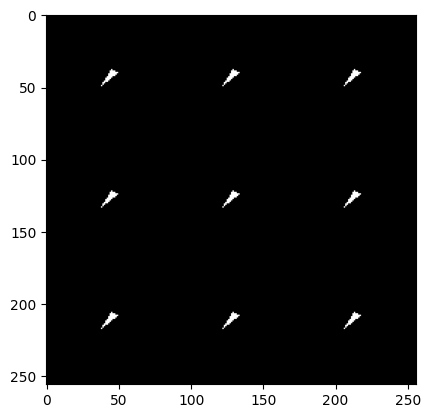

In [36]:
plt.imshow(tri_tensor.permute(1, 2, 0))
plt.show()

In [32]:
img_tensor = process_img(img_path)
show_tensor = torch.where(tri_tensor == 0., img_tensor, tri_tensor)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


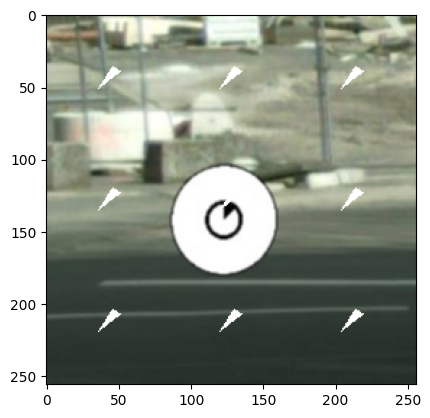

In [33]:
plt.imshow(show_tensor.permute(1, 2, 0))
plt.show()

In [110]:
img_tensor[0, :] = torch.clip(img_tensor[0, :]*1, 0, 1)
img_tensor[1, :] = torch.clip(img_tensor[1, :]*1.5, 0, 1)
img_tensor[2, :] = torch.clip(img_tensor[2, :]*1.5, 0, 1)

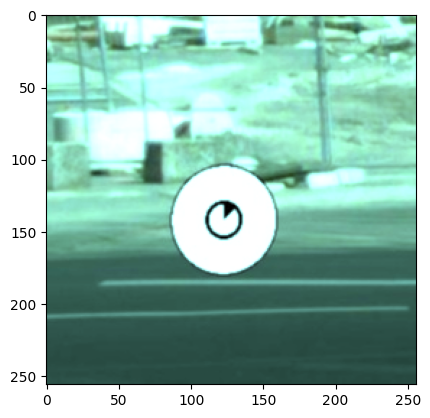

In [111]:
plt.imshow(img_tensor.permute(1, 2, 0))
plt.show()

In [15]:
img_tensor = torch.tensor(img)
img_tensor.shape

torch.Size([256, 256, 3])

## Test on MobileNetV2

In [84]:
model_ids = METADATA[METADATA['model_architecture']==MODEL_ARCH[1]]['model_name'].tolist()

In [39]:
model_ids[0]

'id-00000002'

In [40]:
poisoned_model_id = METADATA[METADATA['poisoned']]['model_name'].tolist()

In [41]:
all_train_triggers = []
for p_model_id in poisoned_model_id:
    # if p_model_id in model_ids:
    #     continue
    model_dir = os.path.join(MODEL_FILEDIR, p_model_id)
    for potential_img_path in os.listdir(model_dir):
        if potential_img_path.startswith('trigger') and potential_img_path.endswith('png'):
            # processed_triggers = process_img(os.path.join(model_dir, potential_img_path), resize=True, resize_res=16, padding=True, padding_pos='arr')
            # all_train_triggers.extend(processed_triggers)
            processed_triggers = process_img(os.path.join(model_dir, potential_img_path), resize=True, resize_res=12, padding=True, padding_pos='all', flat=True)
            all_train_triggers.append(processed_triggers)

In [42]:
all_train_triggers = torch.stack(all_train_triggers, dim=0)

In [43]:
rand_num_for_filter = (1.8-.2)*torch.rand(500-all_train_triggers.shape[0], 3)+.2

In [44]:
rand_num_for_filter = rand_num_for_filter.expand(256, 256, -1, -1).permute(2, 3, 0, 1)

In [85]:
trigger_size, filter_size = all_train_triggers.shape[0], rand_num_for_filter.shape[0]

In [86]:
trigger_size, filter_size

(164, 336)

In [72]:
OUTPUT_FILEDIR = '/scratch/jialin/image-classification-sep2022/projects/trigger_inversion/extracted_source'

In [73]:
np.save(os.path.join(OUTPUT_FILEDIR, 'all_train_triggers.npy'), all_train_triggers.numpy())
np.save(os.path.join(OUTPUT_FILEDIR, 'rand_num_for_filter.npy'), rand_num_for_filter.numpy())

In [47]:
all_train_triggers.shape, rand_num_for_filter.shape

(torch.Size([164, 3, 256, 256]), torch.Size([336, 3, 256, 256]))

In [75]:
1476-36*40

36

In [15]:
def extract_stats(loss_arr, tri_size=164, loop_range=13):
    stats = []
    for i in range(loop_range):
        if i >= 9:
            start_from = 9*tri_size
            interval = (loss_arr.shape[-1] - start_from)//(loop_range-9)
            extracted_loss = loss_arr[:, start_from+(i-9)*interval:start_from+(i-9+1)*interval]
        else:
            ind = [i+9*j for j in range(tri_size)]
            extracted_loss = loss_arr[:, ind]
        stats.extend([np.mean(extracted_loss), np.median(extracted_loss), np.std(extracted_loss), np.max(extracted_loss)])
    return stats

for each batch_size*trigger, extracting mean, median, std, max;
having triggers:[9 insert positions for polygon trigger, 1 ins-filter trigger]

In [87]:
loss_dict = {}
batch_size = 20
# for model_id in tqdm(METADATA['model_name'].tolist()):
for model_id in tqdm(model_ids):
    model_dir = os.path.join(MODEL_FILEDIR, model_id)
    clean_sample_dir = os.path.join(model_dir, 'clean-example-data')
    with torch.no_grad():
        model = torch.load(os.path.join(model_dir, 'model.pt')).to(device)
        model.eval()

    losses = []
    for clean_image in os.listdir(clean_sample_dir):
        if clean_image.endswith('png'):
            processed_image = process_img(os.path.join(clean_sample_dir, clean_image))
            with open(os.path.join(clean_sample_dir, f'{clean_image[:-4]}.json')) as outfile:
                label = json.load(outfile)
            expanded_image = processed_image.expand(batch_size, -1, -1, -1)
            loss_per_img = []
            for i in range((trigger_size+filter_size)//batch_size):
                s_ind, e_ind = batch_size*i, batch_size*(i+1)
                if e_ind < trigger_size:
                    polygon_triggers = all_train_triggers[s_ind:e_ind, :]
                    images = torch.where(polygon_triggers==0, expanded_image, polygon_triggers)
                elif s_ind < trigger_size and e_ind > trigger_size:
                    polygon_triggers = all_train_triggers[s_ind:, :]
                    poly_images = torch.where(polygon_triggers==0, expanded_image[polygon_triggers.shape[0], :], polygon_triggers)
                    filter_triggers = rand_num_for_filter[:e_ind-trigger_size, :]
                    filter_images = torch.clip(filter_triggers*expanded_image[batch_size-filter_triggers.shape[0], :], 0, 1)
                    images = torch.concat([poly_images, filter_images], dim=0)
                else:
                    filter_triggers = rand_num_for_filter[s_ind-trigger_size:e_ind-trigger_size, :]
                    images = torch.clip(filter_triggers*expanded_image, 0, 1)
                with torch.no_grad():
                    logits = model(images.to(device))
                    loss_per_batch = F.cross_entropy(logits, torch.tensor([label]*batch_size).to(device), reduction='none').tolist()
                    loss_per_img += loss_per_batch
            losses.append(loss_per_img)
    # loss_dict[model_id] = extract_stats(np.asarray(losses))
    loss_dict[model_id] = np.concatenate([np.mean(losses, axis=0), np.median(losses, axis=0), np.std(losses, axis=0), np.max(losses, axis=0)]).tolist()

100%|██████████| 96/96 [1:03:13<00:00, 39.52s/it]


In [88]:
with open(os.path.join(OUTPUT_FILEDIR, f'loss_stats_dict_{MODEL_ARCH[1][15:]}.json'), 'w') as outfile:
    json.dump(loss_dict, outfile)

In [89]:
X_with_trigger, X, trigger_only, y = {}, {}, {}, {}
for ma in MODEL_ARCH[1:2]:
    # with open(os.path.join(EXTRACTED_FILEDIR, f'loss_stats_dict_{ma[15:]}.json'), 'r') as outfile:
    #     loss_dict = json.load(outfile)
    y[ma] = np.load(os.path.join(EXTRACTED_FILEDIR, 'weight_only', f'train_y_{ma[15:]}.npy'))
    X[ma] = np.load(os.path.join(EXTRACTED_FILEDIR, 'weight_only', f'train_X_{ma[15:]}.npy'))
    model_order = np.load(os.path.join(EXTRACTED_FILEDIR, 'weight_only', f'train_model_id_{ma[15:]}.npy'))
    loss_order = []
    for mo in model_order:
        loss_order.append(loss_dict[mo])
    loss_order = np.stack(loss_order, axis=0)
    trigger_only[ma] = loss_order
    X_with_trigger[ma] = np.concatenate([X[ma], loss_order], axis=1)

In [90]:
X[ma].shape, X_with_trigger[ma].shape, trigger_only[ma].shape

((96, 1184), (96, 3184), (96, 2000))

## Test on GBM

In [62]:
from sklearn.metrics import log_loss
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

def bootstrap_performance(X, y, clf, n=10, test_size=.2, eps=.01):
    all_cross_entropy, all_accuracy = [], []
    for i in range(n):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=i)
        
        clf.set_params(random_state=i)            
        clf.fit(X_train, y_train)
        
        all_cross_entropy.append(log_loss(y_test, clf.predict_proba(X_test), eps=eps))
        all_accuracy.append(clf.score(X_test, y_test))
    return all_cross_entropy, all_accuracy

In [ ]:
clf_dict = {MODEL_ARCH[0]: GradientBoostingClassifier(learning_rate=0.015, n_estimators=900, max_depth=4, min_samples_split=40, min_samples_leaf=35, max_features=140),
            MODEL_ARCH[1]: GradientBoostingClassifier(learning_rate=0.01, n_estimators=750, max_depth=2, min_samples_split=50, min_samples_leaf=5, max_features=160),
            MODEL_ARCH[2]: GradientBoostingClassifier(learning_rate=0.017, n_estimators=500, max_depth=2, min_samples_split=70, min_samples_leaf=35, max_features=150)}

In [ ]:
N = 50
result = []
import joblib
for ma in MODEL_ARCH:
    with open(os.path.join(OUTPUT_FILEDIR, f'loss_stats_dict_{ma[15:]}.json'), 'r') as outfile:
        loss_dict = json.load(outfile)
    y = np.load(os.path.join(EXTRACTED_FILEDIR, 'weight_only', f'train_y_{ma[15:]}.npy'))
    X = np.load(os.path.join(EXTRACTED_FILEDIR, 'weight_only', f'train_X_{ma[15:]}.npy'))
    model_order = np.load(os.path.join(EXTRACTED_FILEDIR, 'weight_only', f'train_model_id_{ma[15:]}.npy'))
    loss_order = []
    for mo in model_order:
        loss_order.append(loss_dict[mo])
    loss_order = np.stack(loss_order, axis=0)
    X_with_trigger = np.concatenate([X, loss_order], axis=1)
    # np.save(os.path.join(OUTPUT_FILEDIR, f'train_X_{ma[15:]}.npy'), X_with_trigger)
    # result += bootstrap_performance(X, y, clf_dict[ma], N)
    # result += bootstrap_performance(X_with_trigger, y, clf_dict[ma], N)
    # clf = clf_dict[ma].fit(X_with_trigger, y)
    # joblib.dump(clf, os.path.join(OUTPUT_FILEDIR, f'original_{ma[15:]}_clf.joblib'))

In [108]:
ma = MODEL_ARCH[0]
y = np.load(os.path.join(EXTRACTED_FILEDIR, 'weight_only', f'train_y_{ma[15:]}.npy'))
X = np.load(os.path.join(EXTRACTED_FILEDIR, 'weight_only', f'train_X_{ma[15:]}.npy'))
clf = clf_dict[ma].fit(X, y)
joblib.dump(clf, os.path.join('/scratch/jialin/image-classification-sep2022/projects/weight_analysis/for_container/learned_parameters', f'original_{ma[15:]}_clf.joblib'))
X.shape

(96, 1248)

In [110]:
for ma in MODEL_ARCH:
    X = np.load(os.path.join('/scratch/jialin/image-classification-sep2022/projects/weight_analysis/for_container/learned_parameters', f'train_X_{ma[15:]}.npy'))
    print(X.shape)

(96, 1248)
(96, 3184)
(96, 3225)


In [106]:
np.mean(result, axis=1)

array([0.35030875, 0.872     , 0.48853435, 0.853     , 0.39043359,
       0.832     , 0.37182324, 0.854     , 0.53137306, 0.742     ,
       0.411637  , 0.839     ])

In [25]:
import joblib
lpp = '/scratch/jialin/image-classification-sep2022/projects/weight_analysis/for_container/learned_parameters'
for ma in MODEL_ARCH[0:1]:
    np.save(os.path.join(lpp, f'train_X_{ma[15:]}.npy'), X_with_trigger[ma])
    np.save(os.path.join(lpp, f'train_y_{ma[15:]}.npy'), y[ma])
    clf = clf_dict[ma].fit(X_with_trigger[ma], y[ma])
    joblib.dump(clf, os.path.join(lpp, f'original_{ma[15:]}_clf.joblib'))

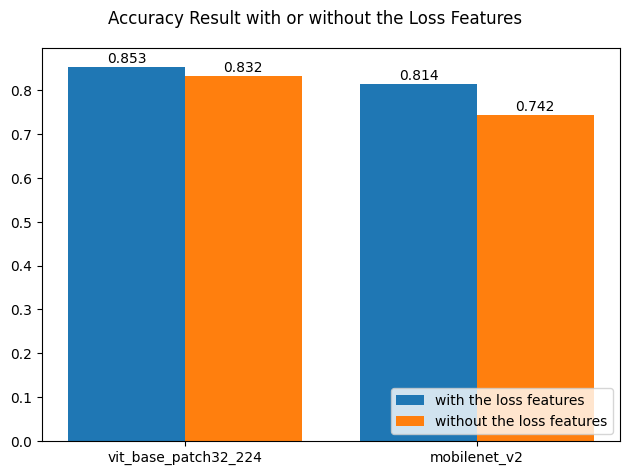

In [26]:
res = [0.37033403, 0.853     , 0.39043359, 0.832     , 0.43583806, 0.814     , 0.53137306, 0.742     ]

fig, ax = plt.subplots()
bar1 = ax.bar(np.arange(2)-.2, [res[1], res[5]], width=0.4, label='with the loss features')
bar2 = ax.bar(np.arange(2)+.2, [res[3], res[7]], width=0.4, label='without the loss features')
ax.set_xticks(np.arange(2), [ma[15:] for ma in MODEL_ARCH[1:]])
plt.legend(loc='lower right')
ax.bar_label(bar1, padding=1)
ax.bar_label(bar2, padding=1)
plt.suptitle('Accuracy Result with or without the Loss Features')
fig.tight_layout()
plt.show()

### Grid Search

In [96]:
ma = MODEL_ARCH[1]
clf = clf_dict[ma]

In [97]:
OUTPUT_FILEDIR = '/scratch/jialin/image-classification-sep2022/projects/trigger_inversion/extracted_source'

In [98]:
with open(os.path.join(OUTPUT_FILEDIR, f'loss_stats_dict_{ma[15:]}.json'), 'r') as outfile:
    loss_dict = json.load(outfile)
y = np.load(os.path.join(EXTRACTED_FILEDIR, 'weight_only', f'train_y_{ma[15:]}.npy'))
X = np.load(os.path.join(EXTRACTED_FILEDIR, 'weight_only', f'train_X_{ma[15:]}.npy'))
model_order = np.load(os.path.join(EXTRACTED_FILEDIR, 'weight_only', f'train_model_id_{ma[15:]}.npy'))
loss_order = []
for mo in model_order:
    loss_order.append(loss_dict[mo])
loss_order = np.stack(loss_order, axis=0)
X = np.concatenate([X, loss_order], axis=1)

In [99]:
X.shape

(96, 3184)

In [100]:
param={'max_depth': range(2, 5), 'min_samples_split': range(10, 201, 10), 'min_samples_leaf': range(5, 101, 5), 'max_features': range(20, 401, 10)}  #cen-.383 acc-.886
# param = {'learning_rate':np.arange(.01, .0201, .001), 'n_estimators':range(300, 1201, 50)}
# param = {'learning_rate':[.01, .005, .015, .03, .0075], 'n_estimators':[650, 1300, 450, 225, 900]}

In [101]:
gsearch = GridSearchCV(estimator=clf, param_grid=param, scoring=['neg_log_loss', 'accuracy'], n_jobs=10, cv=5, refit=False);
gsearch.fit(X, y);

In [102]:
gsearch = pd.DataFrame(gsearch.cv_results_).sort_values(by=['rank_test_neg_log_loss', 'rank_test_accuracy'])
gsearch.to_csv(os.path.join(OUTPUT_FILEDIR, f'gsearch_result_{ma[15:]}.csv'))